# Collaborative filtering at scale with Movie Lens 20M and RAPIDS

In [1]:
%matplotlib inline
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cudf, cupy
import pandas as pd
import numpy as np
import os, sys
from scipy.spatial.distance import cosine
import gc

In [2]:
display_settings = {
    'display.max_columns': 100,
    'display.max_rows':100,
    'display.expand_frame_repr': True,  # Wrap to multiple pages
    'display.precision': 2,
    'display.show_dimensions': True,
    'display.float_format': '{:,.2f}'.format,
    'io.hdf.default_format':'table' # appendable hp5 table
}

for op, value in display_settings.items():
    pd.set_option("{}".format(op), value)

In [3]:
DATA_PATH = "~/backup_folder/SASRec.pytorch/data/ml-20m"

In [4]:
!nvidia-smi

Wed Feb 16 20:03:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.31       Driver Version: 465.31       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
| 35%   22C    P2    60W / 260W |    154MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:AF:00.0 Off |                  N/A |
| 27%   

In [5]:
# use specific device
cupy.cuda.Device(0).use()

In [6]:
#ratings = cudf.read_csv(os.path.join(DATA_PATH, 'ratings.csv'), dtype={"userId":np.int32, "movieId":np.int32, "rating":np.float32}, usecols=["userId", "movieId","rating"])
ratings = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv'), dtype={"userId":np.int32, "movieId":np.int32, "rating":np.float32}, usecols=["userId", "movieId","rating"])

In [7]:
ratings.head()

,userId,movieId,rating
0,1,2,3.50
1,1,29,3.50
2,1,32,3.50
3,1,47,3.50
4,1,50,3.50


In [8]:
ratings.describe()

,userId,movieId,rating
count,"20,000,263.00","20,000,263.00","20,000,263.00"
mean,"69,045.87","9,041.57",3.53
std,"40,038.63","19,789.48",1.05
min,1.00,1.00,0.50
25%,"34,395.00",902.00,3.00
50%,"69,141.00","2,167.00",3.50
75%,"103,637.00","4,770.00",4.00
max,"138,493.00","131,262.00",5.00


In [9]:
print(f"{np.iinfo(np.uint32).max:,}")

4,294,967,295


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 228.9 MB


In [11]:
ratings.userId.values.shape

(20000263,)

## center data

In [12]:
mean_ratings = ratings.groupby(by='userId')['rating'].mean()
mean_ratings.sort_index(inplace=True)
num_ratings = ratings.groupby(by='userId')['rating'].count()
num_ratings.sort_index(inplace=True)

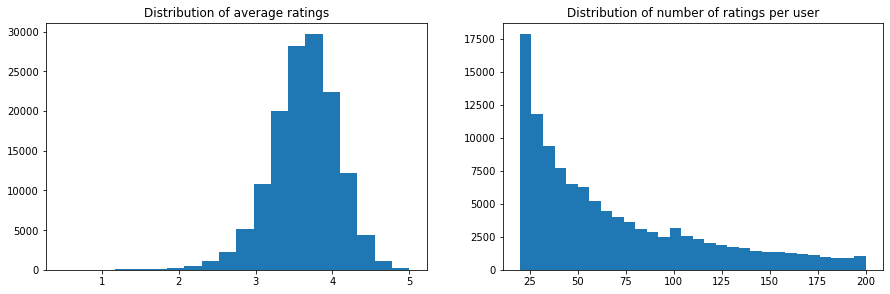

In [13]:
fig = plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Distribution of average ratings')
plt.hist(mean_ratings, bins=20);
plt.subplot(2,2,2)
plt.title('Distribution of number of ratings per user')
plt.hist(num_ratings[num_ratings<=200], bins=30);

In [14]:
# def kernel(userId, rating, centered, kwarg1):
#     for i, (userid, rating) in enumerate(zip(userId,rating)):
#         centered[i] = rating - kwarg1[userid-1]

# ratings.apply_rows(kernel,
#                    incols=['userId', 'rating'],
#                    outcols=dict(centered=np.float32),
#                    kwargs=dict(kwarg1=mean_ratings.values))

In [12]:
ratings['mean_rating'] = ratings.groupby(by='userId')['rating'].transform(np.mean)
ratings['crating'] = ratings['rating'] - ratings['mean_rating']

## Reorder movies 
starting from 0 with no gaps

In [13]:
mv_mapper = {movieId:i for i,movieId in enumerate(ratings.movieId.value_counts().index.values)}
mv_reverse_mapper = {new_id:old_id for old_id,new_id in mv_mapper.items()}

In [14]:
movies = pd.read_csv(os.path.join(DATA_PATH,'movies.csv'))

In [15]:
# top 10 movies not in order of reviews
movies[movies['movieId'].isin([mv_reverse_mapper[i] for i in range(10)])]

,movieId,title,genres
108,110,Braveheart (1995),Action|Drama|War
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
315,318,"Shawshank Redemption, The (1994)",Crime|Drama
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
523,527,Schindler's List (1993),Drama|War
583,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2486,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller


In [16]:
ratings['NmovieId'] = ratings['movieId'].map(mv_mapper)
ratings['userId'] = ratings['userId'] - 1
ratings['userId'] = ratings['userId'].astype(np.uint32)
ratings['NmovieId'] = ratings['NmovieId'].astype(np.uint32)
ratings.head(20)

,userId,movieId,rating,mean_rating,crating,NmovieId
0,0,2,3.50,3.74,-0.24,125
1,0,29,3.50,3.74,-0.24,564
2,0,32,3.50,3.74,-0.24,19
3,0,47,3.50,3.74,-0.24,23
4,0,50,3.50,3.74,-0.24,14
5,0,112,3.50,3.74,-0.24,370
6,0,151,4.00,3.74,0.26,335
7,0,223,4.00,3.74,0.26,106
8,0,253,4.00,3.74,0.26,77
9,0,260,4.00,3.74,0.26,5


## Calculate a metric how many moveis two given users have in common 
we will need this for the short list of users to calculate distance

#### Define the number of chunks to divide the USER-USER matrix  
this is needed cos U-U matrix is too big - won't fit into memory of a GPU

In [65]:
from scipy.sparse import csr_matrix, find
from sklearn.utils import shuffle

In [ ]:
USER_NUM = ratings.userId.max()+1
MOVIE_NUM = len(mv_mapper)

In [18]:
# calculate how we will split the matrix to fit it into GPU memory
# in Gb
MEMORY_LIMIT = 11
for N in range(2,10):
    if USER_NUM/N < 40_000:
        # we have found the N-split
        extra_users = N - USER_NUM%N
        chunk = (USER_NUM+extra_users)//N
        break
print(f"We make {N} splits \nand add {extra_users} extra users to make \none chunk of size {chunk:_} users")
print(f"And in total there will be {N} by {N} = {N**2} matrices each of size {(chunk**2)*(4)/1024/1024/1024:,.2} Gb")

We make 4 splits 
and add 3 extra users to make 
one chunk of size 34_624 users
And in total there will be 4 by 4 = 16 matrices each of size 4.5 Gb


In [19]:
# by the end of this block we have some extra users that makes our user by user matrix divisible by N and we can split User to User matrix in chunks 
# and multiply each one by each one on GPU and then assemble the whole in memory

from copy import deepcopy
add_on_users = deepcopy(ratings.sample(extra_users))
add_on_users.reset_index(drop = True, inplace=True)
add_on_users['index'] = 77
for u in range(0, extra_users):
    add_on_users.loc[u, 'userId'] = USER_NUM + u
    add_on_users.loc[u, 'index'] = ratings.index.max() + u + 1
add_on_users = add_on_users.set_index('index')
ratings = ratings.append(add_on_users)
USER_NUM = ratings.userId.max()+1
ratings.tail()

,userId,movieId,rating,mean_rating,crating,NmovieId
20000261,138492,70286,5.00,4.17,0.83,611
20000262,138492,71619,2.50,4.17,-1.67,6331
20000263,138493,1259,4.00,3.50,0.50,145
20000264,138494,5065,2.00,3.92,-1.92,1695
20000265,138495,4890,2.50,3.53,-1.03,1067


#### Train/Test split  
with respect to first chunk of data

In [20]:
%%time
# this makes a copy of ratings dataframe and chuffles the data
chunk_one_ratings = shuffle(ratings[ratings['userId']<chunk])

CPU times: user 758 ms, sys: 609 ms, total: 1.37 s
Wall time: 1.31 s


In [21]:
TEST_SIZE = 0.2
TT_SPLIT = int(len(chunk_one_ratings)*(1-TEST_SIZE))

In [22]:
%%time
# this makes two views(?) on chuchunk_one_ratings
train_ratings = chunk_one_ratings[:TT_SPLIT]
test_ratings = chunk_one_ratings[TT_SPLIT:]

CPU times: user 177 µs, sys: 107 µs, total: 284 µs
Wall time: 292 µs


In [23]:
# this frees some memory
del chunk_one_ratings
gc.collect()

13

#### Making sparse matrices  
 - scr_binary_ratings - to hold info on what users rated
 - csr_ratings - actual ratings

In [25]:
# creating sparse matrix with information on what movies users have rated
# this is a matrix of movies that each user have rated - it all contains only ones 
csr_binary_ratings = csr_matrix((np.ones_like(train_ratings['crating'].values, dtype=np.float32), 
                           (train_ratings['userId'].values, train_ratings['NmovieId'].values)))

In [26]:
# this is a sparse matrix with actual ratings
csr_ratings = csr_matrix((train_ratings['crating'].values, (train_ratings['userId'].values, train_ratings['NmovieId'].values)))

In [27]:
csr_ratings

<34624x26739 sparse matrix of type '<class 'numpy.float32'>'
	with 4036235 stored elements in Compressed Sparse Row format>

## GPU acceleration
in task of computing the number of common movies for all users

In [28]:
import cupyx.scipy.sparse as cuda_sparse
watched_movies_cuda = cuda_sparse.csr_matrix(csr_binary_ratings)

In [29]:
print(f"That many Gb is required to hold U-U matrix of common movies in memory - {USER_NUM**2*4/1024/1024/1024:,.2f}")

That many Gb is required to hold U-U matrix of common movies in memory - 71.46


In [30]:
print(f"That many Gb is required to hold U-U matri of {chunk} by {chunk} common movies in memory - {chunk*chunk*4/1024/1024/1024:,.2f}")

That many Gb is required to hold U-U matri of 34624 by 34624 common movies in memory - 4.47


In [31]:
%%time
# get the number of common movies for the first chunk users just in 3-4 seconds
chunk_one_cuda = watched_movies_cuda[:chunk]*watched_movies_cuda[:chunk].T

CPU times: user 3 s, sys: 145 ms, total: 3.14 s
Wall time: 3.4 s


### Collect back to CPU and process

In [32]:
%%time
# collect on cpu
chunk_one_cpu = chunk_one_cuda.get().astype(np.uint16)

CPU times: user 5.09 s, sys: 51.5 s, total: 56.6 s
Wall time: 1min 31s


In [33]:
chunk_one_cpu[0].toarray()

array([[140,   8,  27, ...,  31,  14,   7]], dtype=uint16)

## Now let's make recommender for for a particular user for particular movie

In [250]:
from sklearn.metrics import mean_squared_error, r2_score

In [211]:
def user2user_prediction(user_i, movie_j, 
                         user2user_common_cuda, 
                         csr_ratings, 
                         common_movies_fraction = 0.6, similarity_threshold = 0.5, extended_stat=False):
    """
    Givet a user_i, make a prediction of rating for movie_j
    Parameters:
     - user_i, movie_j - user and movie id
     - user2user_common_cuda - a CUPY matrix that holds how many movies in common two users have
     - csr_ratings - a sparse matrix that holds all ratings of users
     - common_movies_fraction - consider only users who have seen at least % of movies that user_i have seen
     - similarity_threshold - consider only users who's similarity to user_i is at least this value
     - extended_stat=False - return a list with the following data for each item impacted the score - n_common_movies, correlation
    """
    COMMON_MOVIES_N = int(csr_ratings[user_i].nnz*common_movies_fraction)
    
    # get users that watched in common with user_i >= COMMON_MOVIES_N
    _, common_users = np.where((user2user_common_cuda[user_i]>=COMMON_MOVIES_N).get().toarray()==True)
    
    # enumerator of the rating
    sum_delta = 0
    # denomitator of the rating
    sum_weights = 0
    SIMILARITY_THRESHHOLD = similarity_threshold

    # get the list of common users who have rated movie_j
    # note that rows are from 0 to len(common_users)
    rows, _ , rating_values  = find(csr_ratings[common_users, movie_j])
    # get all movies that user i has watched
    _, movies_i = csr_ratings[user_i].nonzero()

    # total number of similar users that fit condition w > SIMILARITY_THRESHHOLD
    similar_users = 0
    # stats on the calculation
    # for each user record number of common movies - n_common_movies and actual correlation
    common_users_stat = []

    for pos_ii,rating_ii in zip(rows, rating_values):
        # get id of current user
        user_ii = common_users[pos_ii]
        # if current user is the user_i - continue
        if user_ii == user_i:
            continue
        # get all movies that a user_ii has rated
        _, movies_ii = csr_ratings[user_ii,:].nonzero()
        # get intersection of movies rated by i and ii
        common_movies_i_ii = np.array(list(set(movies_ii).intersection(set(movies_i))))
        # calculate cosine similarity of user_i and user ii 
        w = 1 - cosine(csr_ratings[user_i, common_movies_i_ii].toarray()[0], csr_ratings[user_ii, common_movies_i_ii].toarray()[0])
        # skip if similarity is less then 
        if w < SIMILARITY_THRESHHOLD :
            continue
        sum_delta += rating_ii*w
        sum_weights += abs(w)
        similar_users += 1
        if extended_stat:
            common_users_stat.append({'n_common_movies':len(common_movies_i_ii), 'correlation':round(w,2)})
    try:
        estimated_rating = sum_delta/sum_weights
    except ZeroDivisionError:
        estimated_rating = 0
        
    if extended_stat:
        return (estimated_rating, common_users_stat)
    return estimated_rating

In [212]:
sample_record = test_ratings.sample(1)
sample_record

,userId,movieId,rating,mean_rating,crating,NmovieId
777999,5176,1584,3.50,3.51,-0.01,161


In [258]:
user_i, movie_j, gt_user_i_movie_j_rating = sample_record['userId'].values[0], sample_record['NmovieId'].values[0], sample_record['crating'].values[0]

In [262]:
user2user_prediction(user_i, movie_j, chunk_one_cuda, csr_ratings, common_movies_fraction = 0.2, similarity_threshold = 0.5, extended_stat=True )

(-0.22791244951114736,
 [{'n_common_movies': 46, 'correlation': 0.52},
  {'n_common_movies': 52, 'correlation': 0.52},
  {'n_common_movies': 47, 'correlation': 0.56}])

In [263]:
gt_user_i_movie_j_rating

-0.010373354

In [264]:
predicted_ratings = np.zeros_like(test_ratings.crating.values)
index = 0
for user_i, movie_j in tqdm(test_ratings[['userId', 'NmovieId']].values[:1000]):
    predicted_ratings[index] = user2user_prediction(int(user_i), int(movie_j), 
                                                    chunk_one_cuda, csr_ratings, 
                                                    common_movies_fraction = 0.2, 
                                                    similarity_threshold = 0.6)
    index +=1

  0%|          | 0/1000 [00:00<?, ?it/s]

/opt/conda/envs/rapids/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/envs/rapids/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [265]:
mean_squared_error(test_ratings['crating'].values[:1000], predicted_ratings[:1000])

0.8112501

In [272]:
r2_score(test_ratings['crating'].values[:1000][predicted_ratings[:1000] != 0], predicted_ratings[:1000][predicted_ratings[:1000] != 0])

0.14032851789893253

In [271]:
[predicted_ratings[:1000] != 0]

[array([ True,  True,  True, False, False, False, False,  True, False,
        False, False,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,
        False,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True, False,  True, False,  True,  True,
         True, False, False,  True, False,  True,  True,  True, False,
        False,  True, False, False,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True, False,
        False,  True, False,  True,  True,  True, False, False, False,
        False, False,  True,  True, False, False, False, False,  True,
         True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True, False, False,  True,  True, False,
        False,  True,  True,  True,  True,  True, False,  True,  True,
      